In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(action = 'ignore')

import os
import sys

import cv2
import glob


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import (InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Activation) #the layers needed for our CNN; we didn't end up using Activation (for transformation/squashing)?
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping


from numba import double, jit, njit, vectorize

import progressbar

import time

import PIL
from PIL import Image, ImageEnhance

import math

from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)
from sklearn.utils import shuffle

import pickle

from skimage.transform import resize

from moviepy.editor import VideoFileClip, concatenate_videoclips


In [166]:
path_training_flip   = glob.glob('Houses Dataset/Training Set/Flip_Mixed_Training/Flip_Kitchen_Training/*.jpg')
path_training_noflip = glob.glob('Houses Dataset/Training Set/Dont Flip_Mixed_Training/Dont Flip_Kitchen_Training/*.jpg')

path_testing_flip   = glob.glob('Houses Dataset/Testing Set/Flip_Mixed_Testing/Flip_Kitchen_Testing/*.jpg')
path_testing_noflip = glob.glob('Houses Dataset/Testing Set/Dont Flip_Mixed_Testing/Dont Flip_Kitchen_Testing/*.jpg')

In [167]:
def image_preprocessing(path):
    
    images = []

    for i in path:
        img = cv2.imread(i)
        s=256 #side length in pixels ############tweak
        t=32 #pixels to trim around top ############tweak
        b=16 #bottom trim
        lr=8 #left/right trim
        img = cv2.resize(img, dsize = (s,s), interpolation=cv2.INTER_CUBIC) #keep intercubic he said
        y, h, x, w = b, s-t, lr, s-lr #evenly cut outside border around all sides
        img = img[y:h, x:w]

        alpha=1.5 ############tweak
        beta=.5 ############tweak
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta) #rough/broken understanding: not all the pixels have the same 'intensity' (meaning?), so the brightness won't affect them equally, thus putting zeros attempts to negate/counteract this side effect? #######################
        img = cv2.bitwise_not(img)
        img = img/255.0 #need to make 255.0? need to convert to FLOAT first?? img=img.astype('float32')??

        images.append(img)

    return images

In [168]:
img_training_flip = image_preprocessing(path_training_flip)

img_training_noflip = image_preprocessing(path_training_noflip)

img_testing_flip = image_preprocessing(path_testing_flip)

img_testing_noflip = image_preprocessing(path_testing_noflip)

In [169]:
len(img_training_flip),len(img_training_noflip),len(img_testing_flip),len(img_testing_noflip)

(69, 69, 17, 17)

In [170]:
y_train_flip =   [1 for i in range(len(img_training_flip))]

y_train_noflip = [0 for i in range(len(img_training_noflip))]

y_test_flip =    [1 for i in range(len(img_testing_flip))]

y_test_noflip =  [0 for i in range(len(img_testing_noflip))]

In [171]:
X_train = np.concatenate((img_training_flip, img_training_noflip))

X_test =  np.concatenate((img_testing_flip, img_testing_noflip))

y_train = np.append(y_train_flip, y_train_noflip)

y_test =  np.append(y_test_flip, y_test_noflip)

In [172]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(138, 224, 224, 3)
(138,)
(34, 224, 224, 3)
(34,)


In [173]:
Xy_train = np.array(list(zip(X_train,y_train)))

np.random.shuffle(Xy_train)

Xy_train_shuffle = Xy_train

In [174]:
Xy_test = np.array(list(zip(X_test,y_test)))

np.random.shuffle(Xy_test)

Xy_test_shuffle = Xy_test

In [175]:
X_train_shuffled = []
y_train_shuffled = []

for i in Xy_train_shuffle:
    image = i[0]
    X_train_shuffled.append(image)
    label = i[1]
    y_train_shuffled.append(label)

X_train_shuffled = np.array(X_train_shuffled)

y_train_shuffled = np.array(y_train_shuffled)

In [176]:
X_test_shuffled = []
y_test_shuffled = []

for i in Xy_test_shuffle:
    image = i[0]
    X_test_shuffled.append(image)
    label = i[1]
    y_test_shuffled.append(label)

X_test_shuffled = np.array(X_test_shuffled)

y_test_shuffled = np.array(y_test_shuffled)

In [177]:
print(X_train_shuffled.shape)
print(y_train_shuffled.shape)
print(X_test_shuffled.shape)
print(y_test_shuffled.shape)

(138, 224, 224, 3)
(138,)
(34, 224, 224, 3)
(34,)


In [178]:
def neural_network():
    model = Sequential()
    model.add(Conv2D(256, (3, 3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform', input_shape=(208, 240, 3))) ############tweak #nodes; INSTEAD of putting manually, just do .shape[1] like they did in class? ###match input_size to image resize! 56 is the cropped pixels, after 64!
    model.add(MaxPooling2D((2, 2))) ############tweak??? (2,2) is default??
    model.add(Flatten()) #necessary? >> YES! IF WE HAVE A DENSE/FULLY CONNECTED NETWORK COMING UP NEXT, WHICH WE DO! this isn't a 'layer' tho is it?
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform')) #####tweak? nodes at least. why double here? OR COULD MAKE THIS ANOTHER CONV2D LAYER INSTEAD?! if we do that, we'd add another maxpooling 2d layer after again. wait is this supposed to be Dense too??
    model.add(Dense(1, activation='sigmoid')) ############tweak activ? why doesn't softmax work here?!
    #DROPOUT LAYER - can try! prevents from overfitting??
    
    #why did he have so many nodes in his next to last node than in the FIRST?!

    # opt = SGD(lr=.001,momentum=.9) ############IF NOT USING ADAM, then tweak learning rate & momentum! if using adam, take this out and just put 'adam' in optimizer below!

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    #good thing about ADAM is he TAKES CARE OF TWEAKING THE LEARNING RATE *FOR US*!!!

    return model

In [179]:
model = neural_network()

earlystop = EarlyStopping(monitor='accuracy',patience=3) #changing patience from 2 to 3 def let it run many more epochs

model.fit(X_train_shuffled, y_train_shuffled, callbacks=[earlystop], epochs = 33) ############tweak

Epoch 1/33
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 37s 6s/step - loss: 793.7686 - accuracy: 0.5451
Epoch 2/33
5/5 [==============================] - 24s 5s/step - loss: 546.8979 - accuracy: 0.5436
Epoch 3/33
5/5 [==============================] - 25s 5s/step - loss: 283.9974 - accuracy: 0.5602
Epoch 4/33
5/5 [==============================] - 25s 5s/step - loss: 66

In [180]:
predictions = model.predict(X_test_shuffled)

binary_values = []

for i in predictions:
    if i < .6: ############tweaked from .5
        binary_values.append(0)
    else:
        binary_values.append(1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


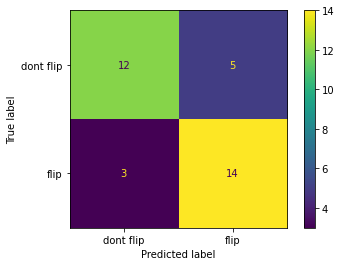

In [181]:
cmx = confusion_matrix(y_test_shuffled, binary_values)

cmd = ConfusionMatrixDisplay(cmx, display_labels=['dont flip','flip'])
cmd.plot();

In [182]:
print(classification_report(y_test_shuffled, binary_values))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        17
           1       0.74      0.82      0.78        17

    accuracy                           0.76        34
   macro avg       0.77      0.76      0.76        34
weighted avg       0.77      0.76      0.76        34



In [183]:
model_classifier = model.save('flip_house_classifier')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: flip_house_classifier/assets


In [184]:
model.evaluate(X_test_shuffled, y_test_shuffled)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 5s 122ms/step - loss: 27.4172 - accuracy: 0.7647


[27.417160034179688, 0.7647058963775635]

In [185]:
#there's that ~79%!

In [186]:
print(binary_values)

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]


In [187]:
print(y_test_shuffled)

[0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0]


In [188]:
len(binary_values)

34

In [189]:
print(list(zip(binary_values,y_test_shuffled)))

[(1, 0), (0, 1), (0, 1), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0), (1, 0), (1, 1), (1, 1), (0, 0), (1, 0), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 0), (0, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 0), (1, 1), (0, 0), (0, 0), (0, 0)]


In [190]:
comparo = pd.DataFrame({'predicted':binary_values, 'truth':y_test_shuffled})

result = []
for i in range(len(binary_values)):
    if binary_values[i] != y_test_shuffled[i]:
        result.append("wrong")
    else:
        result.append("")

comparo['result'] = result

comparo

,predicted,truth,result
0,1,0,wrong
1,0,1,wrong
2,0,1,wrong
3,0,0,
4,0,0,
5,1,1,
6,1,1,
7,0,0,
8,1,1,
9,1,1,


In [191]:
wrongos = comparo.query('result == "wrong"')
wrongos

,predicted,truth,result
0,1,0,wrong
1,0,1,wrong
2,0,1,wrong
11,1,0,wrong
15,1,0,wrong
23,1,0,wrong
24,0,1,wrong
29,1,0,wrong


In [192]:
wrongos.index

Int64Index([0, 1, 2, 11, 15, 23, 24, 29], dtype='int64')

0.png


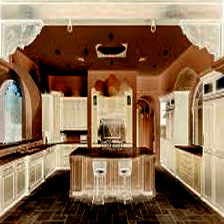

1.png


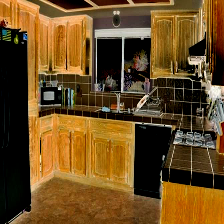

2.png


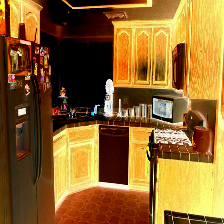

11.png


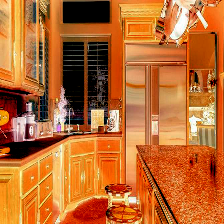

15.png


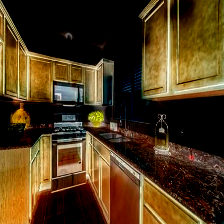

23.png


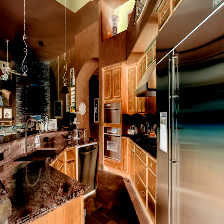

24.png


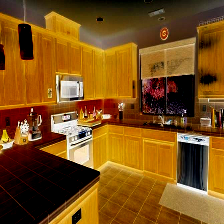

29.png


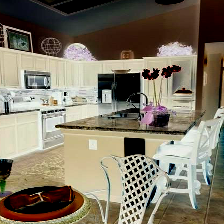

In [193]:
from PIL import Image
# from IPython.display import display

ind = 0

for pic in X_test_shuffled[wrongos.index]:
    array = np.array(pic * 255.0, dtype=np.uint8) #would've done uint8 if kept in raw 255 format, but we converted to be b/w 0<>1!
    img = Image.fromarray(array)
    pic_label = wrongos.index[ind]
    ind += 1
    title = "{}.png".format(pic_label)
    # img.save(title) #oops! lol don't do this cuz this'll save it in this current directory every time! no need!
    # img.show() #opens EXTERNALLY! in Apple/Mac Preview
    print(title)
    display(img) #DISPLAYS IN CONSOLE/HERE IN NOTEBOOK!

In [194]:
# ALHAMDULILLAHI RABBIL 'AALAMEEEEEEN!

In [209]:
# #ahhh okay - so we divided by 255 to get b/w 0/1, but seems like PIL only supports the full 255 form (tried doing dtype=float but same error) so we're simply gonna undo the /255 by *255!
# #so we can use np.uint8
# array = np.array(img_testing_flip[1], dtype=np.uint8)
# img = Image.fromarray(array)
# # img = Image.fromarray(img_testing_flip[1])
# img.save('pic.png')
# img.show()


In [196]:
#wait a minute - we can get a VISUAL FLOWCHART OF THE INPUT THRU THE HIDDEN LAYERS TO THE OUTPUT SEEING
#ALL THE LIKE FRAGMENTS/FEATURES ETC!?!?
# https://www.youtube.com/watch?v=HMcx-zY8JSg
#oh wait - i think he created that - BUT THERE MUST BE A WAY TO *SEE* THE FEATURES / COMPONENTS THRU THE DIFF LAYERS!!!!
#like he had to have gotten those images from code here!

#this is just to display an image in general, once you have it, like from file   
# from IPython.display import Image
# Image()

In [197]:
####################################################################################
#print out predictions and line up with test pictures to see how it classified what!

In [198]:
#USING VALIDATION_SPLIT!

In [199]:
# #let's start from beginning!

# path_training_flip   = glob.glob('Houses Dataset/Training Set/Flip_Mixed_Training/Flip_Kitchen_Training/*.jpg')
# path_training_noflip = glob.glob('Houses Dataset/Training Set/Dont Flip_Mixed_Training/Dont Flip_Kitchen_Training/*.jpg')

# path_testing_flip   = glob.glob('Houses Dataset/Testing Set/Flip_Mixed_Testing/Flip_Kitchen_Testing/*.jpg')
# path_testing_noflip = glob.glob('Houses Dataset/Testing Set/Dont Flip_Mixed_Testing/Dont Flip_Kitchen_Testing/*.jpg')

# img_training_flip = image_preprocessing(path_training_flip)

# img_training_noflip = image_preprocessing(path_training_noflip)

# img_testing_flip = image_preprocessing(path_testing_flip)

# img_testing_noflip = image_preprocessing(path_testing_noflip)

# X = np.concatenate((img_training_flip,img_training_noflip,img_testing_flip,img_testing_noflip))


# y_train_flip =   [1 for i in range(0, len(img_training_flip))]

# y_train_noflip = [0 for i in range(0, len(img_training_noflip))]

# y_test_flip =    [1 for i in range(0, len(img_testing_flip))]

# y_test_noflip =  [0 for i in range(0, len(img_testing_noflip))]

# y = np.concatenate((y_train_flip,y_train_noflip,y_test_flip,y_test_noflip))

# #.FIT() SHUFFLES BY DEFAULT!!! shuffle=True - SO NO NEED TO COMBINE JUST TO SHUFFLE!!!!!
# #couldn't we have utilized built-in auto-shuffle in train/test split way too?!

# model2 = neural_network()

# earlystop = EarlyStopping(monitor='val_accuracy',patience=3)

# model2.fit(X, y, validation_split=.25, callbacks=[earlystop], epochs = 21)#, shuffle=True) >> cuz already does that right?!

In [200]:
# predictions2 = model2.predict(X)

# binary_values2 = []

# for i in predictions2:
#     if i < .5: ############tweak
#         binary_values2.append(0)
#     else:
#         binary_values2.append(1)

In [201]:
##################################################################################################################
#OHHHHHH shooot wait! just realized - since we let it do the splitting up for us for validation, then WE CAN'T
#ACTUALLY SEE HOW IT PERFORMED ON THE VALIDATION SET SPECIFICALLY!?!? like we don't even know WHICH PICS
#it used for the validation, so can't even run it thru the cfmx/classifreport!

#idk if there's a way to see what split it made??

#maybe THAT'S another reason why we should do the training/validation on the TRAINING portion, and then SAVE
#a *RESERVE* set for the FINAL test to see SPECIFIC performance!!!!!

In [202]:
# cmx2 = confusion_matrix(y, binary_values2)

# cmd2 = ConfusionMatrixDisplay(cmx2, display_labels=['dont flip','flip'])
# cmd2.plot();

In [203]:
# print(classification_report(y, binary_values2))